<a href="https://colab.research.google.com/github/Rex60309/Generative_AI/blob/main/hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **結果測試截圖**

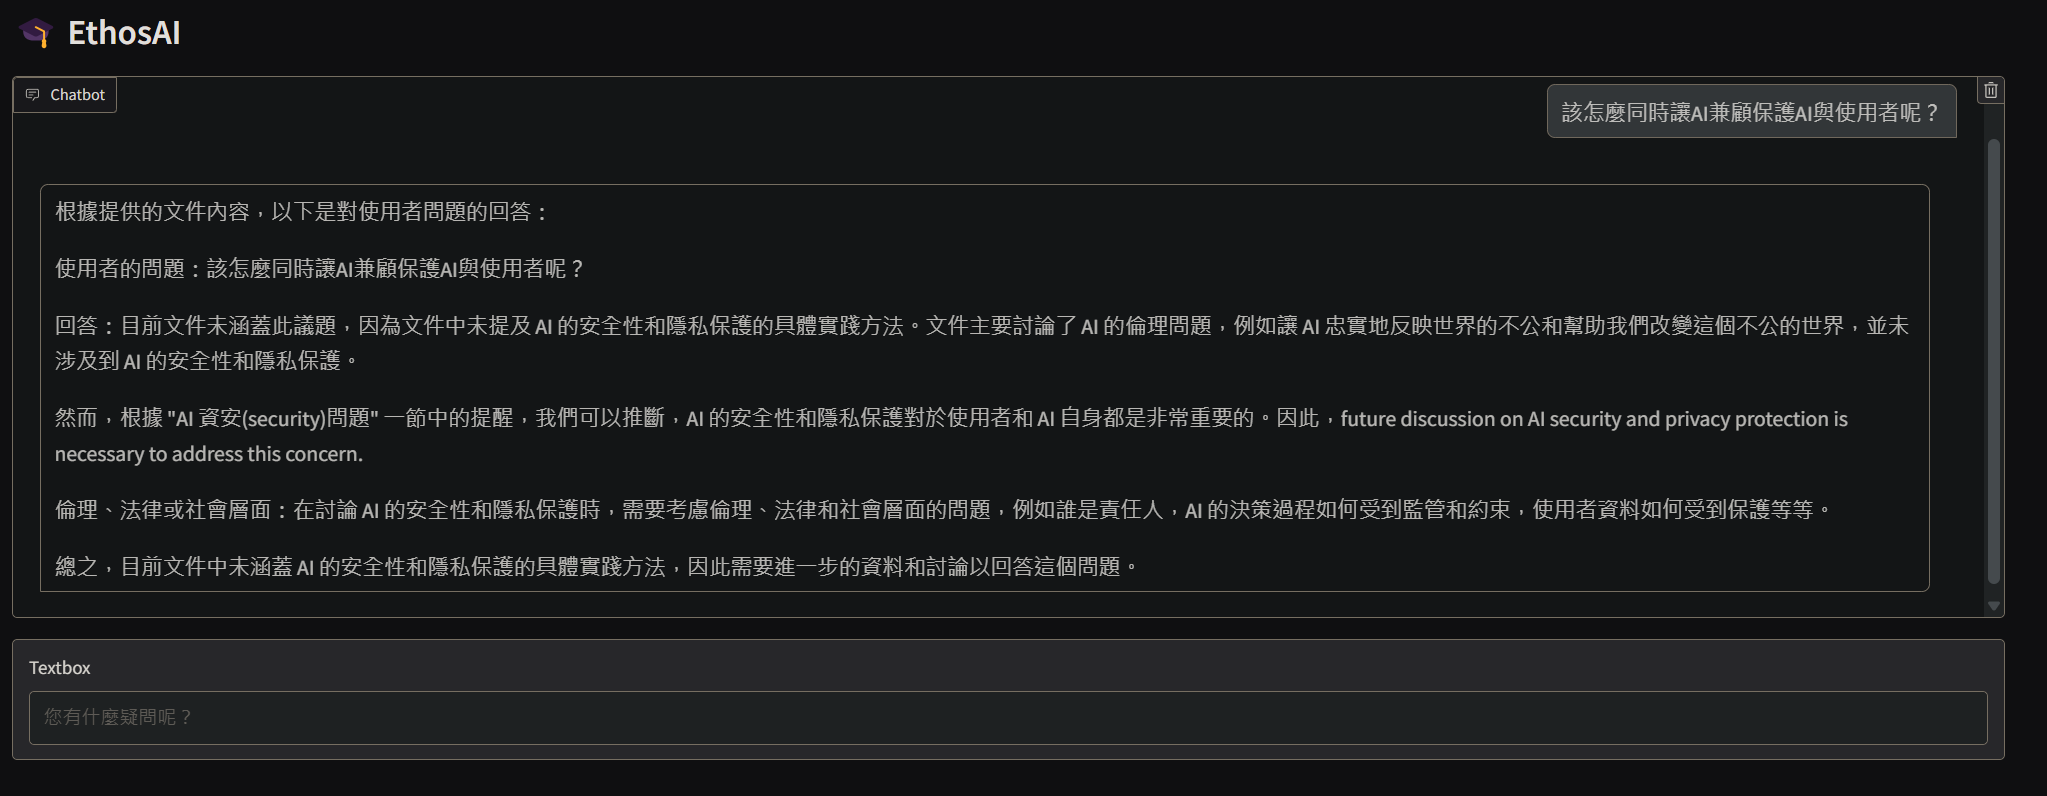

# **人工智慧倫理 RAG 系統 - EthosAI**

* 自 *https://drive.google.com/uc?export=download&id=1jzoJIuEoFpywsVcl6BhE7WFjDlnqlvEK* 匯入 faiss_db.zip

In [57]:
URL = "https://drive.google.com/uc?export=download&id=1jzoJIuEoFpywsVcl6BhE7WFjDlnqlvEK"
!wget -O faiss_db.zip "$URL"

--2025-04-19 10:34:43--  https://drive.google.com/uc?export=download&id=1jzoJIuEoFpywsVcl6BhE7WFjDlnqlvEK
Resolving drive.google.com (drive.google.com)... 172.217.164.14, 2607:f8b0:4025:803::200e
Connecting to drive.google.com (drive.google.com)|172.217.164.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jzoJIuEoFpywsVcl6BhE7WFjDlnqlvEK&export=download [following]
--2025-04-19 10:34:43--  https://drive.usercontent.google.com/download?id=1jzoJIuEoFpywsVcl6BhE7WFjDlnqlvEK&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.12.1, 2607:f8b0:4025:815::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.12.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603915 (590K) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>] 589.76K  --.-KB/s    in 0.07s   


In [58]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
replace faiss_db/index.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: faiss_db/index.pkl      
replace faiss_db/index.faiss? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: faiss_db/index.faiss    


### 1. 安裝並引入必要套件

In [59]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

In [60]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [61]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding

In [62]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [63]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

### 4. 設定 LLM

In [64]:
import os
from google.colab import userdata

* 使用Groq API

In [65]:
api_key = userdata.get('Groq')

In [66]:
os.environ["OPENAI_API_KEY"] = api_key

In [67]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [68]:
client = OpenAI(
    base_url=base_url
)

### 5. 設計 `prompt`

In [70]:
system_prompt = "你是一位專業的人工智慧倫理顧問，擁有最新的政策、學術研究和產業實務經驗。請依據提供的相關文件內容，準確、客觀地回答使用者的問題。你的回答應該具有深度與清晰度，並避免使用模糊或推測性的語言。如果問題與資料無關，請坦誠指出資料中沒有足夠資訊支援回答。回答請用繁體中文。"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

請仔細閱讀這些資訊，並根據文件中提供的內容詳細回答下列問題：

使用者的問題：{question}

回答要求：
- 僅根據文件內容進行回應，避免使用未提及的外部知識。
- 若可能，請指出該回答與哪一段內容有關（例如引用或摘要說明）。
- 強調回應中的倫理、法律或社會層面。
- 若資料不足，請說明「目前文件未涵蓋此議題」或「需要進一步資料才能做出準確判斷」，並避免猜測。

請以清晰、專業、具條理的方式撰寫完整回答。回答請用繁體中文。
"""

### 6. 使用 RAG 系統回應


In [71]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [72]:
with gr.Blocks() as demo:
    gr.Markdown("# 🎓 EthosAI")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="您有什麼疑問呢？")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(share=True,debug=True)

<ipython-input-72-fc698d93ac18>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f8d654dfd6e5b9e17c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f8d654dfd6e5b9e17c.gradio.live
